# Greenhouse time-series model

Walk-forward model that uses external Bet Dagan weather and radiation data as exogenous features to predict internal greenhouse variables (air temp, RH, ET0, internal radiation). Each iteration trains on 1440 rows (10 days at 10 min), tests on 432 rows (3 days), and expands the training window by each 3-day test block.

In [1]:
# Repo paths (works even when notebook is in scripts/)
from pathlib import Path

def find_repo_root(start=None):
    start = Path.cwd() if start is None else Path(start)
    for p in [start, *start.parents]:
        if (p / 'data').exists():
            return p
    return start

ROOT = find_repo_root()
RAW = ROOT / 'data' / 'raw'
PROCESSED = ROOT / 'data' / 'processed'
PLOTS = ROOT / 'plots'
PLOTS.mkdir(exist_ok=True)


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")
DATA_DIR = RAW
TRAIN_WINDOW = 1440  # 10 days of 10-minute samples
TEST_WINDOW = 432    # 3 days of 10-minute samples
GAP = 0            # no skip between train and test blocks
MAX_TRAIN_ROWS = None  # use full history (no cap)
from lightgbm import LGBMRegressor
import lightgbm as lgb


In [3]:
# Load raw files
weather_path = DATA_DIR / "bet_dagan_weather.csv"
radiation_path = DATA_DIR / "bet_dagan_radiation.csv"
micro_path = Path(str(PROCESSED / 'micro_climate_rh_t_et0.xlsx'))

weather = pd.read_csv(weather_path)
radiation = pd.read_csv(radiation_path)
micro = pd.read_excel(micro_path).rename(columns={"internal_rh_%": "internal_rh_pct"})

# Replace Hebrew headers with ASCII names based on column order for reproducibility
weather.columns = [
    "station",
    "timestamp",
    "station_pressure_hpa",
    "rel_humidity_ext",
    "temp_c_ext",
    "temp_max_c_ext",
    "temp_min_c_ext",
    "temp_ground_c_ext",
    "temp_wet_c_ext",
    "wind_dir_deg",
    "gust_dir_deg",
    "wind_speed_ms",
    "wind_speed_max_1m_ms",
    "wind_speed_max_10m_ms",
    "wind_speed_max_10m_time",
    "gust_speed_ms",
    "wind_dir_std_deg",
]

radiation.columns = [
    "rad_station",
    "timestamp",
    "diffuse_rad_wm2",
    "global_rad_wm2",
    "direct_rad_wm2",
]

# Drop station id columns; we only need the measurements
weather = weather.drop(columns=["station"])
radiation = radiation.drop(columns=["rad_station"])

# Convert numeric columns
for df in (weather, radiation, micro):
    for col in df.columns:
        if col not in ("timestamp", "timestamp_dayfirst"):
            df[col] = pd.to_numeric(df[col], errors="coerce")

# Robust parse for micro timestamps (handles mixed formats)
micro_ts_raw = micro["timestamp_dayfirst"].astype(str).str.replace("Î“××Ÿ", "", regex=False).str.strip()
micro_ts = micro_ts_raw.apply(lambda x: pd.to_datetime(x, dayfirst=True, errors="coerce"))
unparsed = micro_ts.isna().sum()
if unparsed:
    print(f"Warning: {unparsed} micro rows had unparsable timestamps; dropping them")
micro = micro.assign(timestamp=micro_ts).dropna(subset=["timestamp"])

# Ensure micro is sorted and truncated to the expected campaign window
micro = micro.sort_values("timestamp").reset_index(drop=True)
expected_start = pd.Timestamp("2025-05-29 01:00:00")
micro = micro[micro["timestamp"] >= expected_start].reset_index(drop=True)

# Parse weather/radiation timestamps
weather["timestamp"] = pd.to_datetime(weather["timestamp"], dayfirst=True, format="mixed")
radiation["timestamp"] = pd.to_datetime(radiation["timestamp"], dayfirst=True, format="mixed")

weather = weather.drop(columns=[c for c in weather.columns if weather[c].isna().all()])
radiation = radiation.drop(columns=[c for c in radiation.columns if radiation[c].isna().all()])

# Moisture physics features
def calculate_saturation_vapor_pressure(temp_c):
    return 0.61078 * np.exp((17.27 * temp_c) / (temp_c + 237.3))

def calculate_vpd(temp_c, rh_pct):
    es = calculate_saturation_vapor_pressure(temp_c)
    ea = es * (rh_pct / 100.0)
    return es - ea

def calculate_absolute_humidity(temp_c, rh_pct):
    return (6.112 * np.exp((17.67 * temp_c) / (temp_c + 243.5)) * rh_pct * 2.1674) / (273.15 + temp_c)

weather["vpd_ext"] = calculate_vpd(weather["temp_c_ext"], weather["rel_humidity_ext"])
weather["abs_humidity_ext"] = calculate_absolute_humidity(weather["temp_c_ext"], weather["rel_humidity_ext"])
weather["dew_point_ext"] = weather["temp_c_ext"] - ((100 - weather["rel_humidity_ext"]) / 5)

weather.head(), radiation.head(), micro.head()


(            timestamp  station_pressure_hpa  rel_humidity_ext  temp_c_ext  \
 0 2025-05-29 00:00:00                1009.0                70        21.5   
 1 2025-05-29 00:10:00                1008.9                70        21.5   
 2 2025-05-29 00:20:00                1008.8                70        21.5   
 3 2025-05-29 00:30:00                1008.8                71        21.4   
 4 2025-05-29 00:40:00                1008.8                71        21.3   
 
    temp_max_c_ext  temp_min_c_ext  temp_ground_c_ext  wind_dir_deg  \
 0            21.5            21.4               20.8           240   
 1            21.5            21.5               20.8           245   
 2            21.5            21.4               20.5           247   
 3            21.4            21.3               20.4           242   
 4            21.4            21.3               20.3           245   
 
    gust_dir_deg  wind_speed_ms  wind_speed_max_1m_ms  wind_speed_max_10m_ms  \
 0           238      

In [4]:
# Align all sources on timestamp; keep micro as the spine to avoid dropping target rows when weather/radiation are missing
target_cols = ["internal_air_temp_c", "internal_radiation", "ET0", "internal_rh_pct"]
merged = micro.merge(weather, on="timestamp", how="left").merge(radiation, on="timestamp", how="left")
missing_rate = merged.isna().mean() * 100
display(missing_rate.sort_values(ascending=False))
# Reindex to a continuous 10-minute grid using the micro (target) span; fill only exogenous columns
full_range = pd.date_range(micro["timestamp"].min(), micro["timestamp"].max(), freq="10min")
reindexed = merged.set_index("timestamp").reindex(full_range)
reindexed.index.name = "timestamp"
reindexed = reindexed.reset_index()
exogenous_cols = [c for c in reindexed.columns if c not in target_cols + ["timestamp", "timestamp_dayfirst"]]
reindexed = reindexed.set_index("timestamp")
reindexed[exogenous_cols] = reindexed[exogenous_cols].interpolate(method="time").bfill().ffill()
reindexed = reindexed.reset_index()
# Drop rows only if targets are missing
data = reindexed.dropna(subset=target_cols).sort_values("timestamp").reset_index(drop=True)
print(f"Rows after aligning, reindexing, and filling exogenous gaps: {len(data):,}")
print(f"Time span: {data['timestamp'].iloc[0]} -> {data['timestamp'].iloc[-1]}")

OUTLIER = [
    (pd.Timestamp("2025-09-11 00:00"), pd.Timestamp("2025-09-11 10:50")),
    (pd.Timestamp("2025-09-18 06:00"), pd.Timestamp("2025-09-18 09:00")),
    (pd.Timestamp("2025-08-27 08:00"), pd.Timestamp("2025-08-27 14:00")),
    (pd.Timestamp("2025-08-28 08:00"), pd.Timestamp("2025-08-28 11:00")),
]
if OUTLIER:
    before = len(data)
    for start, end in OUTLIER:
        data = data[(data["timestamp"] < start) | (data["timestamp"] > end)]
    removed = before - len(data)
    print(f"Removed {removed} rows based on OUTLIER")
    data = data.reset_index(drop=True)


# Calendar features
if 'timestamp' in data.columns:
    data['hour_of_day'] = data['timestamp'].dt.hour
    data['day_of_year'] = data['timestamp'].dt.dayofyear

# Rolling medians to smooth noisy externals (6-step = 60 minutes)
smooth_cols = [
    "global_rad_wm2",
    "diffuse_rad_wm2",
    "direct_rad_wm2",
    "temp_c_ext",
    "rel_humidity_ext",
]
for c in smooth_cols:
    if c in data.columns:
        data[f"{c}_med6"] = data[c].rolling(window=6, min_periods=1).median()  # causal (past-only)

# External vapor pressure deficit (VPD) and dew point
if {"temp_c_ext", "rel_humidity_ext"}.issubset(data.columns):
    data["vpd_ext_calc"] = calculate_vpd(data["temp_c_ext"], data["rel_humidity_ext"])
    data["dew_point_ext_calc"] = data["temp_c_ext"] - ((100 - data["rel_humidity_ext"]) / 5)

# Engineered gradients/trends (trimmed to features used in importance plot)
if "dew_point_ext_calc" in data.columns and "temp_c_ext" in data.columns:
    data["dewpoint_gradient"] = data["dew_point_ext_calc"] - data["temp_c_ext"]

if "vpd_ext_calc" in data.columns:
    data["vpd_ext_rolling_mean_30min"] = data["vpd_ext_calc"].rolling(window=3, min_periods=1).mean()
    data["vpd_ext_min_1h"] = data["vpd_ext_calc"].rolling(window=6, min_periods=1).min()

if "global_rad_wm2" in data.columns:
    data["rad_integral_1h"] = data["global_rad_wm2"].rolling(window=6, min_periods=1).sum()
    data["rad_peak_intensity"] = data["global_rad_wm2"].rolling(window=6, min_periods=1).max()
    # Radiation ramp speed (positive at sunrise, negative at sunset)
    data["rad_slope_30m"] = data["global_rad_wm2"].diff(periods=3)  # 3*10min
    data["rad_slope_1h"] = data["global_rad_wm2"].diff(periods=6)   # 6*10min
    # Sunrise/Sunset heuristics from external radiation
    RAD_TRANSITION_THRESHOLD = 5  # W/m^2 threshold to mark day/night
    data["rad_is_low"] = data["global_rad_wm2"] <= RAD_TRANSITION_THRESHOLD
    data["sunrise_flag"] = (~data["rad_is_low"]) & (data["rad_is_low"].shift(1, fill_value=True))
    data["sunset_flag"] = data["rad_is_low"] & (~data["rad_is_low"].shift(1, fill_value=False))
    # Minutes since sunrise (only during daylight)
    sunrise_groups = data["sunrise_flag"].cumsum()
    data["minutes_since_sunrise"] = data.groupby(sunrise_groups).cumcount() * 10
    data.loc[data["rad_is_low"], "minutes_since_sunrise"] = np.nan
    # Minutes since sunset (only during darkness)
    sunset_groups = data["sunset_flag"].cumsum()
    data["minutes_since_sunset"] = data.groupby(sunset_groups).cumcount() * 10
    data.loc[~data["rad_is_low"], "minutes_since_sunset"] = np.nan



exclude_cols = ["internal_air_temp_c", "ET0", "internal_radiation"]
feature_cols = [c for c in data.columns if c not in target_cols + ["timestamp", "timestamp_dayfirst"] + exclude_cols]

# Optional: drop low-importance externals to speed up (populate list as needed)
LOW_IMPORTANCE_DROP = []
feature_cols = [c for c in feature_cols if c not in LOW_IMPORTANCE_DROP]
data.head()


diffuse_rad_wm2          0.929145
ET0                      0.000000
internal_air_temp_c      0.000000
internal_rh_pct          0.000000
internal_radiation       0.000000
timestamp                0.000000
station_pressure_hpa     0.000000
rel_humidity_ext         0.000000
timestamp_dayfirst       0.000000
temp_c_ext               0.000000
temp_max_c_ext           0.000000
temp_ground_c_ext        0.000000
temp_min_c_ext           0.000000
gust_dir_deg             0.000000
wind_speed_ms            0.000000
wind_speed_max_1m_ms     0.000000
wind_dir_deg             0.000000
wind_speed_max_10m_ms    0.000000
gust_speed_ms            0.000000
vpd_ext                  0.000000
wind_dir_std_deg         0.000000
abs_humidity_ext         0.000000
dew_point_ext            0.000000
global_rad_wm2           0.000000
direct_rad_wm2           0.000000
dtype: float64

Rows after aligning, reindexing, and filling exogenous gaps: 16,682
Time span: 2025-05-29 01:00:00 -> 2025-09-21 23:00:00
Removed 141 rows based on OUTLIER


,timestamp,timestamp_dayfirst,ET0,internal_air_temp_c,internal_rh_pct,internal_radiation,station_pressure_hpa,rel_humidity_ext,temp_c_ext,temp_max_c_ext,...,vpd_ext_min_1h,rad_integral_1h,rad_peak_intensity,rad_slope_30m,rad_slope_1h,rad_is_low,sunrise_flag,sunset_flag,minutes_since_sunrise,minutes_since_sunset
0,2025-05-29 01:00:00,29/05/2025 01:00:00,0.027900,22.775547,74.709380,0.0,1008.8,70.0,21.4,21.4,...,0.764606,0.0,0.0,NaN,NaN,True,False,True,NaN,0.0
1,2025-05-29 01:10:00,29/05/2025 01:10:00,0.022799,22.743830,74.193410,0.0,1008.7,70.0,21.3,21.3,...,0.759937,0.0,0.0,NaN,NaN,True,False,False,NaN,10.0
2,2025-05-29 01:20:00,29/05/2025 01:20:00,0.020941,22.473650,73.349106,0.0,1008.7,70.0,21.2,21.3,...,0.755292,0.0,0.0,NaN,NaN,True,False,False,NaN,20.0
3,2025-05-29 01:30:00,29/05/2025 01:30:00,0.020224,22.452467,71.715630,0.0,1008.7,68.0,21.1,21.2,...,0.755292,0.0,0.0,0.0,NaN,True,False,False,NaN,30.0
4,2025-05-29 01:40:00,29/05/2025 01:40:00,0.015574,22.511518,71.976640,0.0,1008.8,70.0,21.0,21.2,...,0.746077,0.0,0.0,0.0,NaN,True,False,False,NaN,40.0


In [5]:
# Define model and expanding walk-forward routine
# LightGBM estimators (faster than XGBoost defaults)
base_estimator = LGBMRegressor(
    n_estimators=700,
    learning_rate=0.04,
    num_leaves=80,
    max_depth=-1,
    min_child_samples=35,
    subsample=0.8,
    subsample_freq=1,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.1,
    min_split_gain=0.0,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
)

rh_feature_cols = None  # set after stage-1 predictions are available
rh_estimator = LGBMRegressor(
    n_estimators=700,
    learning_rate=0.04,
    num_leaves=64,
    max_depth=-1,
    min_child_samples=55,
    subsample=0.8,
    subsample_freq=1,
    colsample_bytree=0.8,
    reg_lambda=2.0,
    reg_alpha=0.2,
    min_split_gain=0.0,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
)

EARLY_STOPPING_ROUNDS = 0  # set to 0/None to disable

def features_for_target(target):
    if target == "internal_rh_pct":
        if rh_feature_cols is None:
            raise ValueError("rh_feature_cols not set; define before RH walk_forward")
        return rh_feature_cols
    return feature_cols

def estimator_for_target(target):
    return rh_estimator if target == "internal_rh_pct" else base_estimator

def clip_predictions(target, preds):
    if target == "internal_rh_pct":
        return np.clip(preds, 0, 100)
    if target in ("ET0", "internal_radiation"):
        return np.clip(preds, 0, None)
    return preds

def walk_forward(df, feature_cols, target_cols, model, train_window=TRAIN_WINDOW, test_window=TEST_WINDOW, gap=GAP, max_train_rows=MAX_TRAIN_ROWS):
    """Expanding-window walk-forward: grow train set by each test block."""
    metrics = []
    preds = []
    train_end = train_window
    test_end = train_end + test_window
    run = 0

    while test_end <= len(df):
        train_start_idx = max(0, train_end - max_train_rows) if max_train_rows else 0
        train = df.iloc[train_start_idx:train_end]
        test = df.iloc[train_end:test_end]

        preds_run = {}
        metric = {
            "run": run,
            "train_start": train["timestamp"].iloc[0],
            "train_end": train["timestamp"].iloc[-1],
            "test_start": test["timestamp"].iloc[0],
            "test_end": test["timestamp"].iloc[-1],
            "train_rows": len(train),
            "test_rows": len(test),
        }

        for t_col in target_cols:
            feat_cols_t = features_for_target(t_col)
            model_t = estimator_for_target(t_col)
            model_t = clone(model_t)  # fresh instance

            fit_kwargs = {}
            train_fit = train
            model_t.fit(train_fit[feat_cols_t], train_fit[t_col], **fit_kwargs)
            pred_t = model_t.predict(test[feat_cols_t])
            pred_t = clip_predictions(t_col, pred_t)
            preds_run[t_col] = pred_t
            metric[f"mae_{t_col}"] = mean_absolute_error(test[t_col], pred_t)
            mse = mean_squared_error(test[t_col], pred_t)
            metric[f"rmse_{t_col}"] = np.sqrt(mse)
            metric[f"r2_{t_col}"] = r2_score(test[t_col], pred_t)

        metrics.append(metric)
        preds.append(
            pd.concat(
                [
                    test[["timestamp"] + target_cols].reset_index(drop=True),
                    pd.DataFrame({f"pred_{t}": preds_run[t] for t in target_cols}),
                ],
                axis=1,
            ).assign(run=run)
        )

        print(
            f"Run {run}: train {metric['train_rows']} rows ({metric['train_start']} -> {metric['train_end']}), "
            f"test {metric['test_rows']} rows ({metric['test_start']} -> {metric['test_end']})"
        )
        for t_col in target_cols:
            print(
                f"  {t_col}: MAE={metric[f'mae_{t_col}']:.4f}, RMSE={metric[f'rmse_{t_col}']:.4f}, R2={metric[f'r2_{t_col}']:.4f}"
            )

        run += 1
        train_end += test_window  # expand training window by one test block (3 days)
        test_end = train_end + test_window

    if not metrics:
        raise ValueError("Not enough data for a single walk-forward run; check window sizes.")

    return pd.DataFrame(metrics), pd.concat(preds, ignore_index=True)


In [6]:


RUN_RH_ONLY = False  # set True to train/predict only internal RH

all_targets = ["internal_air_temp_c", "internal_radiation", "ET0", "internal_rh_pct"]
stage1_targets = ["internal_air_temp_c", "internal_radiation", "ET0"]
target_cols = ["internal_rh_pct"] if RUN_RH_ONLY else all_targets

# Stage 2 (RH) uses only external features
rh_features = [c for c in feature_cols if c not in all_targets]
rh_feature_cols = rh_features

metrics_main = preds_main = None
metrics_rh = preds_rh = None

data_for_run = data.copy()

if target_cols:
    metrics_main, preds_main = walk_forward(
        data_for_run, feature_cols, target_cols, base_estimator, max_train_rows=MAX_TRAIN_ROWS
    )
    display(metrics_main)

    if "internal_rh_pct" in target_cols:
        metrics_rh = metrics_main
        preds_rh = preds_main[["timestamp", "internal_rh_pct", "pred_internal_rh_pct", "run"]]
else:
    print("No targets selected; nothing to run")


def summarize_metrics(metrics_df, preds_df, targets):
    rows = []
    for t in targets:
        row = {"variable": t}
        mean_actual = preds_df[t].mean() if preds_df is not None and t in preds_df else None
        for metric in ("mae", "rmse", "r2"):
            col = f"{metric}_{t}"
            if metrics_df is not None and col in metrics_df:
                row[metric] = metrics_df[col].mean()
        if mean_actual and row.get("mae") is not None and mean_actual != 0:
            row["mae_pct"] = row["mae"] / mean_actual * 100
        rows.append(row)
    return rows

if metrics_main is not None:
    summary_main = pd.DataFrame(summarize_metrics(metrics_main, preds_main, target_cols))
    display(summary_main)

# Optional saves
if metrics_main is not None:
    if RUN_RH_ONLY:
        metrics_main.to_csv(PROCESSED / 'rh_metrics_stage2_3day_3daystep.csv', index=False)
        if preds_rh is not None:
            preds_rh.to_csv(PROCESSED / 'rh_predictions_stage2_3day_3daystep.csv', index=False)
    else:
        metrics_main.to_csv(PROCESSED / 'metrics_all_targets_3day_3daystep.csv', index=False)
        preds_main.to_csv(PROCESSED / 'predictions_all_targets_3day_3daystep.csv', index=False)



Run 0: train 1440 rows (2025-05-29 01:00:00 -> 2025-06-08 00:50:00), test 432 rows (2025-06-08 01:00:00 -> 2025-06-11 00:50:00)
  internal_air_temp_c: MAE=0.5432, RMSE=0.6638, R2=0.9722
  internal_radiation: MAE=32.2479, RMSE=66.9783, R2=0.9231
  ET0: MAE=0.0219, RMSE=0.0435, R2=0.9557
  internal_rh_pct: MAE=5.3752, RMSE=6.4979, R2=0.6317
Run 1: train 1872 rows (2025-05-29 01:00:00 -> 2025-06-11 00:50:00), test 432 rows (2025-06-11 01:00:00 -> 2025-06-14 00:50:00)
  internal_air_temp_c: MAE=0.3474, RMSE=0.4779, R2=0.9877
  internal_radiation: MAE=33.6817, RMSE=61.0809, R2=0.9389
  ET0: MAE=0.0271, RMSE=0.0440, R2=0.9549
  internal_rh_pct: MAE=2.7909, RMSE=3.6502, R2=0.8647
Run 2: train 2304 rows (2025-05-29 01:00:00 -> 2025-06-14 00:50:00), test 432 rows (2025-06-14 01:00:00 -> 2025-06-17 01:00:00)
  internal_air_temp_c: MAE=0.3263, RMSE=0.4076, R2=0.9901
  internal_radiation: MAE=18.5874, RMSE=33.0546, R2=0.9811
  ET0: MAE=0.0169, RMSE=0.0291, R2=0.9802
  internal_rh_pct: MAE=2.0215, 

,run,train_start,train_end,test_start,test_end,train_rows,test_rows,mae_internal_air_temp_c,rmse_internal_air_temp_c,r2_internal_air_temp_c,mae_internal_radiation,rmse_internal_radiation,r2_internal_radiation,mae_ET0,rmse_ET0,r2_ET0,mae_internal_rh_pct,rmse_internal_rh_pct,r2_internal_rh_pct
0,0,2025-05-29 01:00:00,2025-06-08 00:50:00,2025-06-08 01:00:00,2025-06-11 00:50:00,1440,432,0.543247,0.663754,0.972192,32.247931,66.978288,0.923069,0.021854,0.043493,0.955706,5.375231,6.497944,0.631661
1,1,2025-05-29 01:00:00,2025-06-11 00:50:00,2025-06-11 01:00:00,2025-06-14 00:50:00,1872,432,0.347390,0.477907,0.987707,33.681742,61.080856,0.938894,0.027138,0.043990,0.954918,2.790926,3.650166,0.864742
2,2,2025-05-29 01:00:00,2025-06-14 00:50:00,2025-06-14 01:00:00,2025-06-17 01:00:00,2304,432,0.326289,0.407635,0.990149,18.587450,33.054644,0.981142,0.016850,0.029109,0.980173,2.021501,2.591815,0.937162
3,3,2025-05-29 01:00:00,2025-06-17 01:00:00,2025-06-17 01:10:00,2025-06-20 01:00:00,2736,432,0.375236,0.493638,0.986795,16.871225,28.288777,0.987268,0.013077,0.020325,0.990603,2.463778,3.485396,0.877369
4,4,2025-05-29 01:00:00,2025-06-20 01:00:00,2025-06-20 01:10:00,2025-06-23 01:00:00,3168,432,0.342081,0.438946,0.988626,14.434768,24.902488,0.989488,0.010644,0.018690,0.991875,1.898247,2.889655,0.907378
5,5,2025-05-29 01:00:00,2025-06-23 01:00:00,2025-06-23 01:10:00,2025-06-26 01:00:00,3600,432,0.365721,0.508678,0.980158,20.019092,34.227542,0.978742,0.016015,0.028039,0.980528,1.652058,2.164233,0.960637
6,6,2025-05-29 01:00:00,2025-06-26 01:00:00,2025-06-26 01:10:00,2025-06-29 01:00:00,4032,432,0.483984,0.683181,0.978660,32.991510,70.833223,0.938516,0.022850,0.038187,0.971309,3.221788,4.551238,0.851393
7,7,2025-05-29 01:00:00,2025-06-29 01:00:00,2025-06-29 01:10:00,2025-07-02 01:10:00,4464,432,0.461552,0.664966,0.977019,22.503354,40.278549,0.976897,0.016117,0.027403,0.984478,3.230692,4.143889,0.892414
8,8,2025-05-29 01:00:00,2025-07-02 01:10:00,2025-07-02 01:20:00,2025-07-05 01:10:00,4896,432,0.398924,0.530402,0.984290,14.418029,24.572671,0.992244,0.011019,0.017643,0.993740,1.921884,2.408749,0.940057
9,9,2025-05-29 01:00:00,2025-07-05 01:10:00,2025-07-05 01:20:00,2025-07-08 01:10:00,5328,432,0.293388,0.386076,0.990621,18.808680,33.723019,0.979738,0.011587,0.021379,0.990612,1.473254,1.876103,0.965353


,variable,mae,rmse,r2,mae_pct
0,internal_air_temp_c,0.427356,0.574944,0.973371,1.492912
1,internal_radiation,22.216770,43.407080,0.967170,11.396855
2,ET0,0.016774,0.032154,0.971858,10.520910
3,internal_rh_pct,2.740356,3.586756,0.860742,3.819581


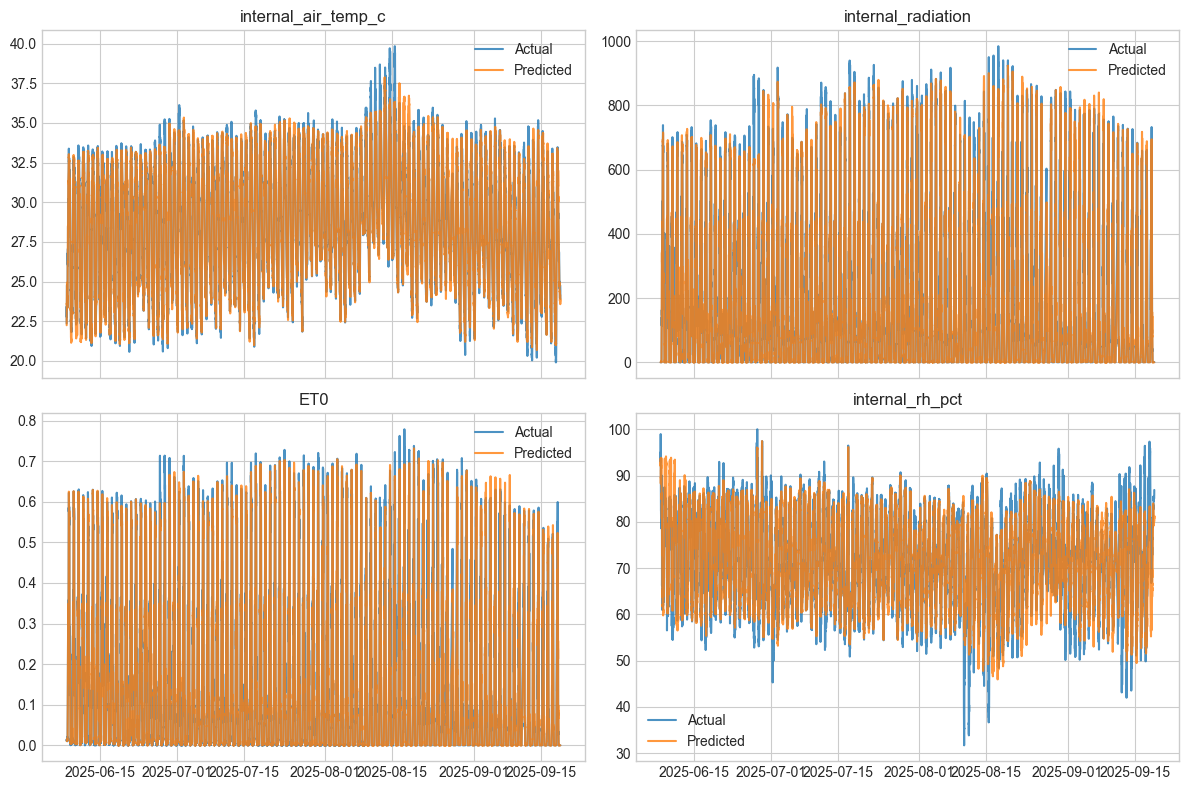

In [7]:
# Plot predicted vs actual internal climate (4 targets)
if preds_main is None:
    print("No predictions available; run walk_forward first.")
else:
    plot_targets = ["internal_air_temp_c", "internal_radiation", "ET0", "internal_rh_pct"]
    available = [t for t in plot_targets if t in preds_main.columns and f"pred_{t}" in preds_main.columns]
    if not available:
        print("No matching prediction columns found.")
    else:
        fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
        axes = axes.ravel()
        for ax, t in zip(axes, plot_targets):
            if t not in preds_main.columns or f"pred_{t}" not in preds_main.columns:
                ax.set_visible(False)
                continue
            ax.plot(preds_main["timestamp"], preds_main[t], label="Actual", alpha=0.8)
            ax.plot(preds_main["timestamp"], preds_main[f"pred_{t}"], label="Predicted", alpha=0.8)
            ax.set_title(t)
            ax.legend()
        plt.tight_layout()
        plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_3008\3513904095.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=sub, palette='viridis')


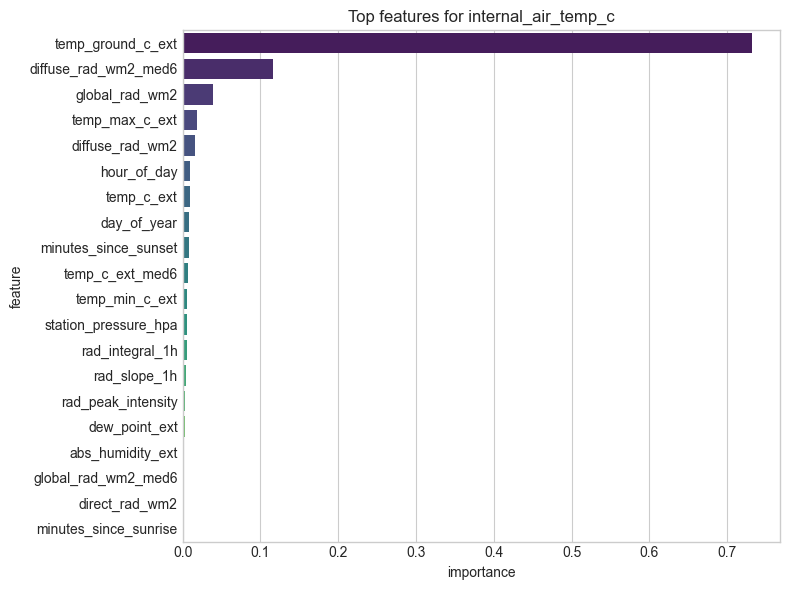

C:\Users\User\AppData\Local\Temp\ipykernel_3008\3513904095.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=sub, palette='viridis')


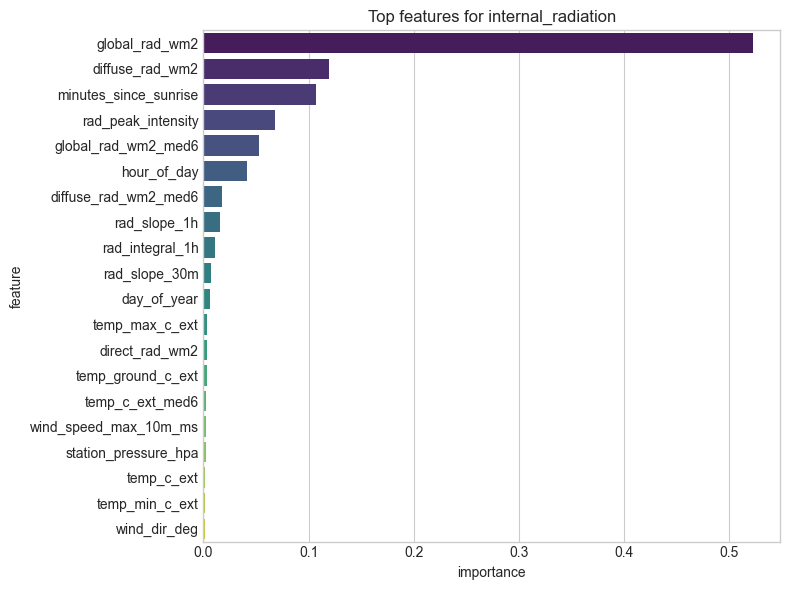

C:\Users\User\AppData\Local\Temp\ipykernel_3008\3513904095.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=sub, palette='viridis')


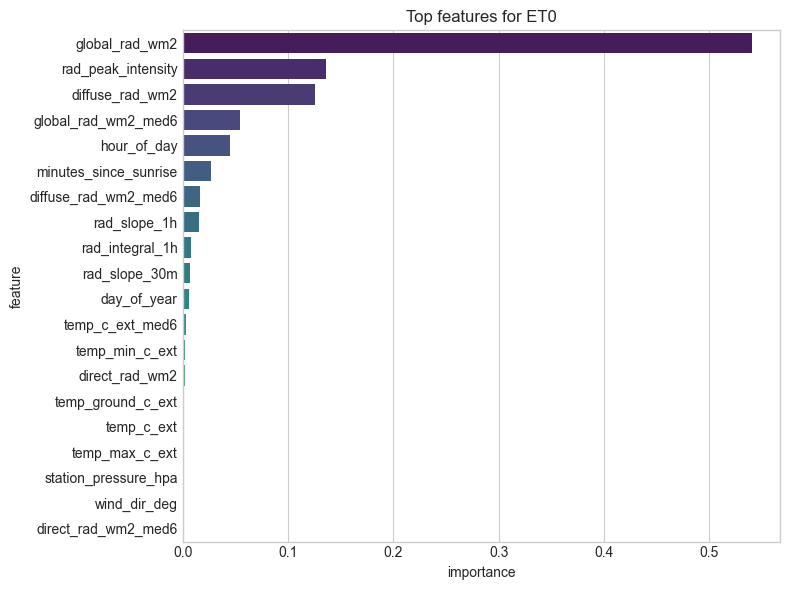

C:\Users\User\AppData\Local\Temp\ipykernel_3008\3513904095.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=sub, palette='viridis')


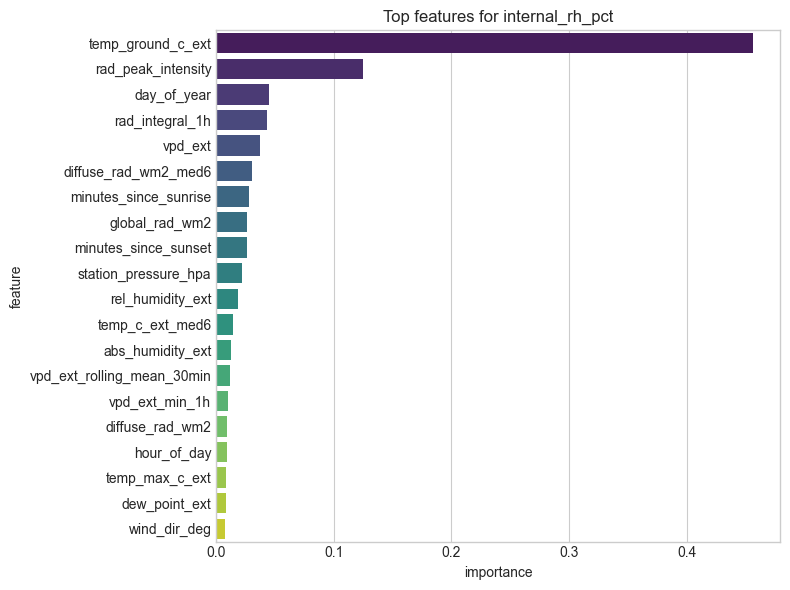

In [8]:

# Feature importance per target (trained once on full dataset)
# Uses external features for RH (rh_feature_cols) and full feature set for other targets

if target_cols:
    importance_rows = []
    for target in target_cols:
        feat_cols_t = rh_feature_cols if target == "internal_rh_pct" else feature_cols
        model_t = clone(base_estimator)
        X = data[feat_cols_t]
        y = data[target]
        model_t.fit(X, y)
        fi = model_t.booster_.feature_importance(importance_type="gain")
        importance_rows.append(pd.DataFrame({"feature": feat_cols_t, "importance": fi, "target": target}))

    if importance_rows:
        importance_df = pd.concat(importance_rows, ignore_index=True)
        for target in target_cols:
            sub = importance_df[importance_df['target'] == target].copy()
            sub['importance'] = sub['importance'] / sub['importance'].sum()
            sub = sub.sort_values('importance', ascending=False).head(20)
            plt.figure(figsize=(8, 6))
            sns.barplot(x='importance', y='feature', data=sub, palette='viridis')
            plt.title(f'Top features for {target}')
            plt.tight_layout()
            plt.show()
else:
    print("Importance skipped (no targets)")



Found 4 low-R2 runs: [0, 26, 31, 33]


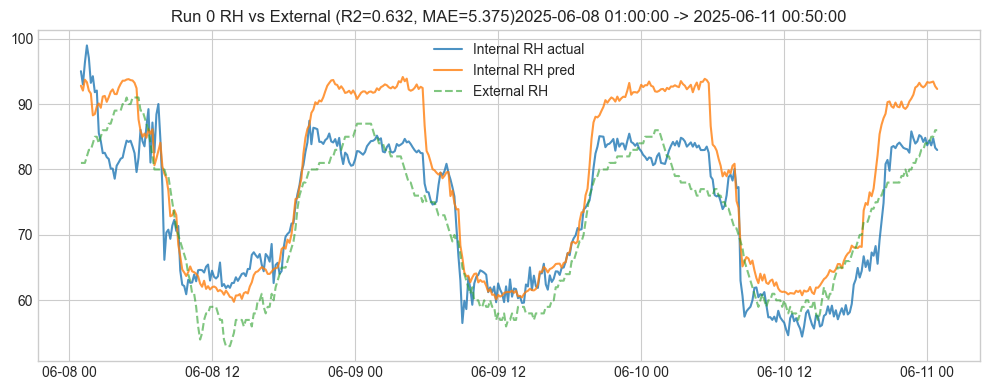

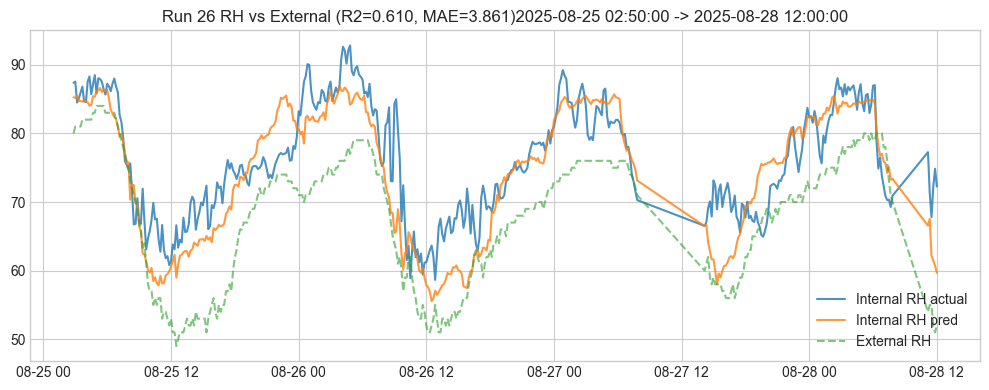

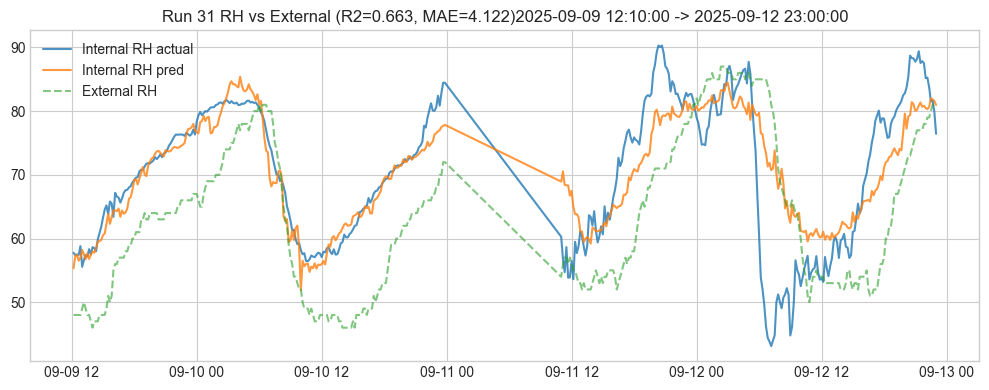

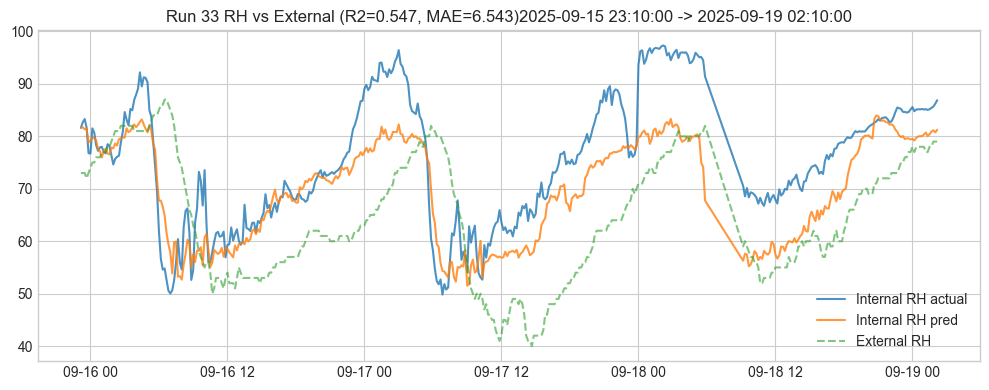

In [9]:

# Plot internal RH vs external RH for runs with low R2 (<0.7)
metrics_df = metrics_rh
preds_df = preds_rh
if metrics_df is None or preds_df is None:
    print('RH mode not run; skipping RH vs external plot')
else:
    bad_runs = metrics_df[metrics_df.get('r2_internal_rh_pct', 1) < 0.7]
    if bad_runs.empty:
        print('No runs with r2_internal_rh_pct < 0.7')
    else:
        print(f"Found {len(bad_runs)} low-R2 runs: {bad_runs['run'].tolist()}")
        for _, row in bad_runs.iterrows():
            r = int(row['run'])
            test_start = row['test_start']
            test_end = row['test_end']
            sub_pred = preds_df[preds_df['run'] == r]
            ext_slice = data[(data['timestamp'] >= test_start) & (data['timestamp'] <= test_end)][['timestamp', 'rel_humidity_ext']]
            if sub_pred.empty or ext_slice.empty:
                print(f'Run {r}: missing data; skipping')
                continue
            merged = sub_pred.merge(ext_slice, on='timestamp', how='left')
            plt.figure(figsize=(10, 4))
            plt.plot(merged['timestamp'], merged['internal_rh_pct'], label='Internal RH actual', alpha=0.8)
            if 'pred_internal_rh_pct' in merged.columns:
                plt.plot(merged['timestamp'], merged['pred_internal_rh_pct'], label='Internal RH pred', alpha=0.8)
            plt.plot(merged['timestamp'], merged['rel_humidity_ext'], label='External RH', alpha=0.6, linestyle='--')
            if 'global_rad_wm2' in merged.columns:
                plt.plot(merged['timestamp'], merged['global_rad_wm2'], label='External Global Rad', alpha=0.5, linestyle=':')
            plt.title(f"Run {r} RH vs External (R2={row['r2_internal_rh_pct']:.3f}, MAE={row['mae_internal_rh_pct']:.3f}){test_start} -> {test_end}")
            plt.legend()
            plt.tight_layout()
            plt.show()



c:\Users\User\anaconda3\envs\tf-cpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


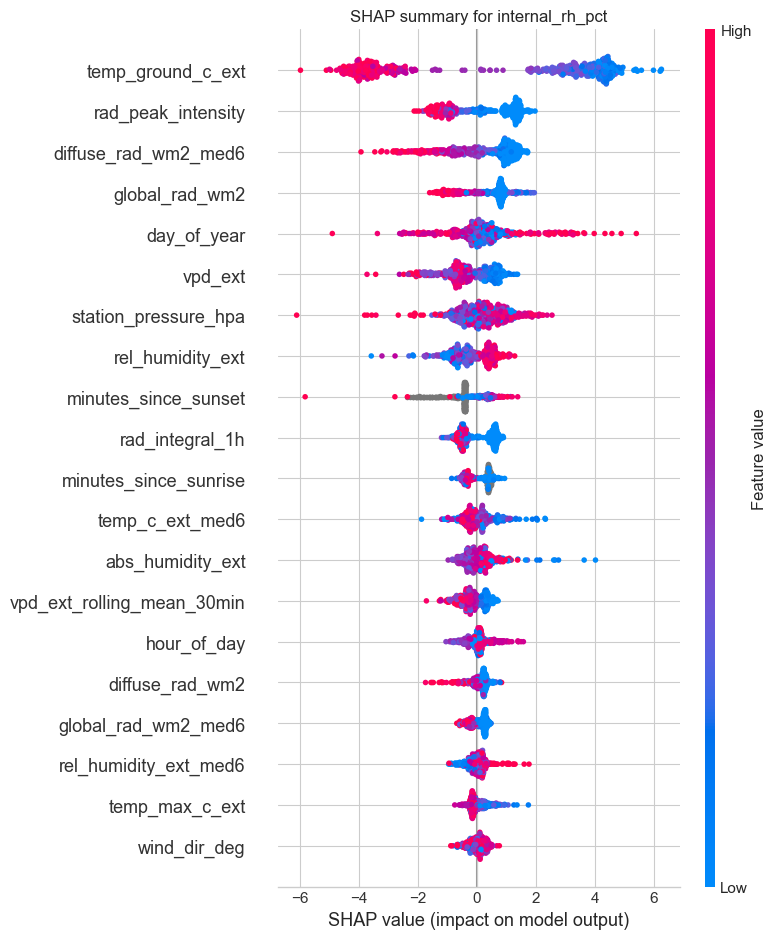

In [10]:

# SHAP explanation for RH (LightGBM)
if 'internal_rh_pct' not in target_cols:
    print('RH not in target list; skipping SHAP')
else:
    try:
        import shap
    except Exception as e:
        print(f"SHAP not available: {e}")
    else:
        shap.initjs()

        model_rh = clone(base_estimator)
        model_rh.fit(data[rh_feature_cols], data['internal_rh_pct'])

        sample_n = min(500, len(data))
        shap_sample = data.sample(sample_n, random_state=42)
        explainer = shap.TreeExplainer(model_rh)
        shap_values = explainer.shap_values(shap_sample[rh_feature_cols])
        shap.summary_plot(shap_values, shap_sample[rh_feature_cols], show=False)
        plt.title("SHAP summary for internal_rh_pct")
        plt.tight_layout()
        plt.show()

